In [1]:
import requests
import json, math, sys, time
import openai, re
from openai import AzureOpenAI
from dotenv import load_dotenv
import os, time, glob
from tqdm import tqdm
from statistics import mode
from sklearn.metrics import confusion_matrix
import pandas as pd
from tqdm import tqdm

load_dotenv()

True

In [2]:
samori_folder = f"{os.getenv('OAK')}/samori"
comments_folder = f"{samori_folder}/tiktok/comments"
persons_folder = f"{samori_folder}/tiktok/persons"

In [90]:
ann_files = [f"{persons_folder}/gpt_annotations_1740783487.7482183.txt", f"{persons_folder}/gpt_annotations_1740936384.455138.txt"]

In [98]:
df = pd.DataFrame()
for ann_file in ann_files:
    df_temp = pd.read_csv(ann_file, delimiter="\t")
    df = pd.concat([df, df_temp])

In [99]:
df = df[df["annotation"] != "'None'"]
df

,id,annotation,explanation,time
0,7.246531e+18,'001',The comment primarily describes another indivi...,1.740784e+09
1,7.325092e+18,'100',The main drug-related message comes from the s...,1.740784e+09
2,7.247243e+18,'100',The comment is centered on the speaker’s perso...,1.740784e+09
3,7.300002e+18,'100',The primary drug-related narrative is the spea...,1.740784e+09
4,7.258723e+18,'001',The comment focuses on expressing love for ano...,1.740784e+09
...,...,...,...,...
57895,7.261684e+18,'001',The comment describes fentanyl's lethality aff...,1.741055e+09
57896,7.329908e+18,'100',"The use of ""we"" indicates a first-person plura...",1.741055e+09
57897,7.273756e+18,'001',"The comment discusses politicians' behavior, l...",1.741055e+09
57898,7.327231e+18,'110',The comment includes the speaker's own experie...,1.741055e+09


In [100]:
annotations = list(df["annotation"])
annotations = [i[1:-1] for i in annotations]

In [101]:
first = len([i for i in annotations if i == "100"])
second = len([i for i in annotations if i == "010"])
third = len([i for i in annotations if i == "001"])

first_second = len([i for i in annotations if i == "110"])
first_third = len([i for i in annotations if i == "101"])
second_third = len([i for i in annotations if i == "011"])

all_intersection = len([i for i in annotations if i == "111"])
none_class = len([i for i in annotations if i == "000"])

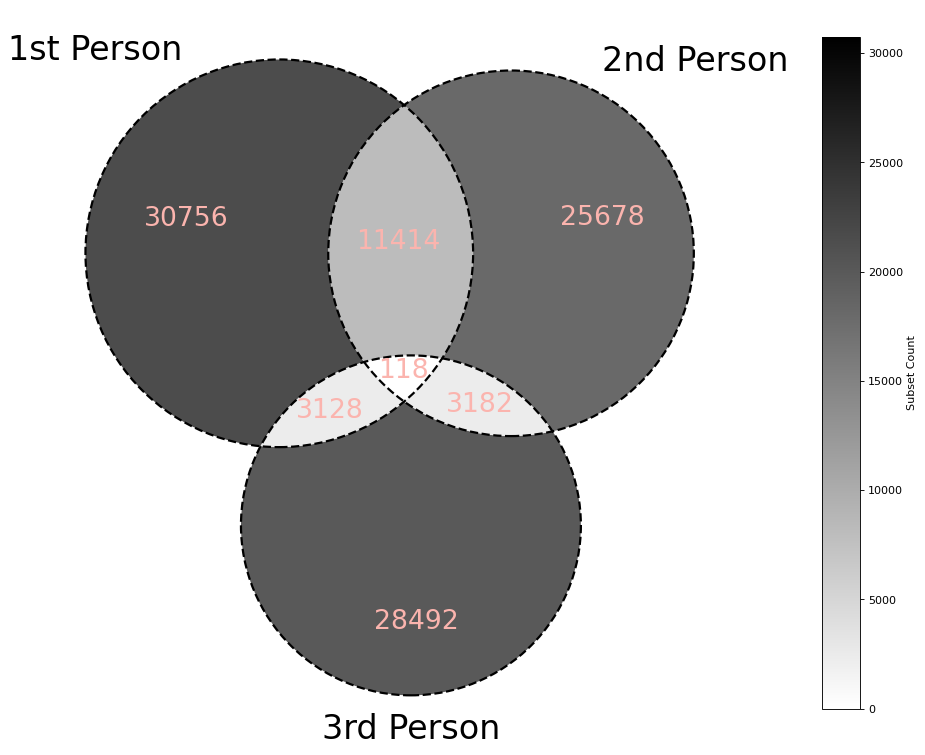

In [133]:
from matplotlib_venn import venn3, venn3_circles
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable
from matplotlib.pyplot import figure

figure(figsize=(16, 12), dpi=80)

venn_tuple = (first, second, first_second, third, first_third, second_third, all_intersection)

region_counts = {
    "100": first,
    "010": second,
    "001": third,
    "110": first_second,
    "101": first_third,
    "011": second_third,
    "111": all_intersection}

max_val = max(venn_tuple)
cmap = cm.binary
norm = mcolors.Normalize(vmin=0, vmax=max_val)



v = venn3(subsets=venn_tuple, 
          set_labels=('1st Person', '2nd Person', '3rd Person'), 
          alpha=0.7)

venn3_circles(subsets=venn_tuple, linestyle="dashed", linewidth=2) 

intensities = []
for region, count in region_counts.items():
    patch = v.get_patch_by_id(region)
    if patch is not None:
        intensity = count / max_val  
        intensities.append(intensity)
        patch.set_facecolor(cmap(intensity))

if v.set_labels is not None:
    for text_obj in v.set_labels:
        if text_obj is not None:
            text_obj.set_fontsize(30)  # change 18 to your desired font size

if v.subset_labels is not None:
    for i in range(len(v.subset_labels)):
        label = v.subset_labels[i]
        if label is not None:
            label.set_horizontalalignment('center')
            label.set_verticalalignment('center')
            # label.set_color("white")
            # label.set_color(cm.Set1(0.2))
            label.set_color(cm.Pastel1(0))
            label.set_fontsize(24)

sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

fig = plt.gcf()

cax = fig.add_axes([0.85, 0.15, 0.03, 0.7])
cbar = plt.colorbar(sm, cax=cax)
cbar.set_label("Subset Count")
plt.savefig("venn_diagram.svg", dpi=300)
plt.show()

In [110]:
cm.Greys(2)

(0.9963091118800461, 0.9963091118800461, 0.9963091118800461, 1.0)

In [140]:
df[df['annotation']=="'111'"]['id']

301      7.257650e+18
1124     7.264612e+18
4318     7.334917e+18
4622     7.319697e+18
5559     7.292832e+18
             ...     
50474    7.363477e+18
50815    7.307208e+18
51979    7.268335e+18
52188    7.248233e+18
53409    7.203679e+18
Name: id, Length: 118, dtype: float64

In [143]:
df[df['annotation']=="'111'"]['id'][4318]

7.334916945688724e+18

In [ ]:
from matplotlib_venn import venn3, venn3_circles
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable

venn_tuple = (first, second, first_second, third, first_third, second_third, all_intersection)

region_counts = {
    "100": first,
    "010": second,
    "001": third,
    "110": first_second,
    "101": first_third,
    "011": second_third,
    "111": all_intersection}

max_val = max(venn_tuple)
cmap = cm.binary
norm = mcolors.Normalize(vmin=0, vmax=max_val)



v = venn3(subsets=venn_tuple, 
      set_labels=('1st Person', '2nd Person', '3rd Person'), 
      set_colors=("red", "yellow", "green"), alpha=0.7)

venn3_circles(subsets=venn_tuple, linestyle="dashed", linewidth=2) 

intensities = []
for region, count in region_counts.items():
    patch = v.get_patch_by_id(region)
    if patch is not None:
        intensity = count / max_val  
        intensities.append(intensity)
        patch.set_facecolor(cmap(intensity))

if v.subset_labels is not None:
    for i in range(len(v.subset_labels)):
        label = v.subset_labels[i]
        if label is not None:
            label.set_horizontalalignment('center')
            label.set_verticalalignment('center')
            # label.set_color("white")
            label.set_color(cm.hot(0))

sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

fig = plt.gcf()

cax = fig.add_axes([0.85, 0.15, 0.03, 0.7])
cbar = plt.colorbar(sm, cax=cax)
cbar.set_label("Subset Count")

plt.show()

In [82]:
cm.hot(1)

(0.05189484405443485, 0.0, 0.0, 1.0)

In [61]:
intensities

[1.0,
 0.8394864549419497,
 0.9341482892069537,
 0.3717673075741753,
 0.10492044965906996,
 0.10485902082437497,
 0.0034400147429203267]

In [24]:
none_class

10190

In [16]:
df['annotation'].unique()

array(["'001'", "'100'", "'010'", "'101'", "'000'", "'110'", "'011'",
       "'111'"], dtype=object)

In [6]:
from matplotlib_venn import venn2, venn2_circles 

In [24]:
len(annotations[0]), len(annotations[0][1:-1])

(5, 3)

In [10]:
df["annotation"].unique()

array(["'001'", "'100'", "'010'", "'101'", "'000'", "'110'", "'None'",
       "'011'", "'111'"], dtype=object)

In [16]:
df[df["annotation"] != "'None'"]

,id,annotation,explanation,time
0,7.246531e+18,'001',The comment primarily describes another indivi...,1.740784e+09
1,7.325092e+18,'100',The main drug-related message comes from the s...,1.740784e+09
2,7.247243e+18,'100',The comment is centered on the speaker’s perso...,1.740784e+09
3,7.300002e+18,'100',The primary drug-related narrative is the spea...,1.740784e+09
4,7.258723e+18,'001',The comment focuses on expressing love for ano...,1.740784e+09
...,...,...,...,...
65820,7.253543e+18,'100',The comment centers on the speaker’s personal ...,1.740917e+09
65821,7.356256e+18,'010',The comment directly addresses another person ...,1.740917e+09
65822,7.250181e+18,'001',The comment primarily describes others’ drug-r...,1.740917e+09
65823,7.224360e+18,'100',The comment focuses on the speaker and Joey’s ...,1.740917e+09
